In [46]:
from rdkit import Chem
from rdkit.Chem import QED, RDConfig, Descriptors, DataStructs, AllChem

import pandas as pd
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer
import networkx as nx
import matplotlib.pyplot as plt


In [35]:
# Modified from https://github.com/bowenliu16/rl_graph_generation
def penalized_logp(s):
    if s is None: return -100.0
    mol = Chem.MolFromSmiles(s)
    if mol is None: return -100.0

    #edit after evaluating across the entire dataset
    logP_mean = 2.4570953396190123
    logP_std = 1.434324401111988
    SA_mean = -3.0525811293166134
    SA_std = 0.8335207024513095
    cycle_mean = -0.0485696876403053
    cycle_std = 0.2860212110245455

    log_p = Descriptors.MolLogP(mol)
    SA = -sascorer.calculateScore(mol)
    
    # cycle score
    cycle_list = nx.cycle_basis(nx.Graph(Chem.rdmolops.GetAdjacencyMatrix(mol)))
    if len(cycle_list) == 0:
        cycle_length = 0
    else:
        cycle_length = max([len(j) for j in cycle_list])
    if cycle_length <= 6:
        cycle_length = 0
    else:
        cycle_length = cycle_length - 6
    cycle_score = -cycle_length

    normalized_log_p = (log_p - logP_mean) / logP_std
    normalized_SA = (SA - SA_mean) / SA_std
    normalized_cycle = (cycle_score - cycle_mean) / cycle_std
    
    return normalized_log_p + normalized_SA + normalized_cycle

def qed(s):
    if s is None: return -100.0
    mol = Chem.MolFromSmiles(s)
    if mol is None: return -100.0
    qed_score = QED.qed(mol)

    qed_mean = 3.0343956
    qed_std = 0.13719133
    #implement again when full dataset compute complete
    normalized_qed = (qed_score - qed_mean) / qed_std

    return qed_score

def calc_prop(s, score_type):
    if score_type=='PLOGP':
        return penalized_logp(s)
    elif score_type=='QED':
        return qed(s)
    else:
        return ValueError('input property type')
    
    

In [51]:
#similarity-based virtual screening assumes that all compounds that are structurally similar to a query compound have similar biological activity
#if the Tanimoto similarity is greater than 0.4, two structures are considered similar
#set threshold = 0.4 - scores are very small on average (mean = 0.17) and the bulk is located below 0.4 (https://academic.oup.com/bioinformatics/article/24/13/i357/236514)

def calc_similarity(s1, s2):
    mol1 = Chem.MolFromSmiles(s1)
    mol2 = Chem.MolFromSmiles(s2)
    if mol1 is None or mol2 is None: return 0.0
    fps_source = AllChem.GetMorganFingerprint(mol1, 2, useChirality=False)
    fps_target = AllChem.GetMorganFingerprint(mol2, 2, useChirality=False)

    sim_score = DataStructs.TanimotoSimilarity(fps_source, fps_target)
    return sim_score


In [59]:
#dataset from https://github.com/wengong-jin/iclr19-graph2graph/tree/master
df_qed = pd.read_csv('/Users/jihyeonje/Desktop/data/qed/train_pairs.txt', header=None, sep=' ') #sim coef 0.4, qed from [0.7,0.8] to [0.9,1.0]
df_plogp = pd.read_csv('/Users/jihyeonje/Desktop/data/logp04/train_pairs.txt', header=None, sep=' ') #sim coef 0.4 


In [184]:
smi = df_qed[0][1]
mol = Chem.MolFromSmiles(smi)

#start processing 3D coordinates
updated_mol= Chem.AddHs(mol)
AllChem.EmbedMolecule(updated_mol)
AllChem.UFFOptimizeMolecule(updated_mol)
updated_mol.GetConformer()

#to get atom type, coordinate, edges
mblock = Chem.MolToMolBlock(updated_mol)
print(mblock)



can ignore from down here

In [ ]:
print()
allcoors = []
for i, atom in enumerate(updated_mol.GetAtoms()):
    positions = updated_mol.GetConformer().GetAtomPosition(i)
    atomdict = {"type": atom.GetSymbol(), 'x': positions.x, 'y': positions.y, 'z': positions.z}
    allcoors.append(atomdict)

In [172]:
def mol_to_nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())
        
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   weight=bond.GetBondTypeAsDouble(),
                   bond_type=bond.GetBondType())
        
    return G

In [189]:
mblock = Chem.MolToMolBlock(updated_mol)
print(mblock)


     RDKit          3D

 50 53  0  0  0  0  0  0  0  0999 V2000
    2.3717    2.2724    2.4154 O   0  0  0  0  0  0  0  0  0  0  0  0
    2.0801    1.0913    2.0859 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.6502    0.1371    3.1733 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.5945   -1.2590    2.7104 N   0  0  0  0  0  0  0  0  0  0  0  0
    2.8095   -2.0441    2.6850 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.9143   -1.5197    2.9936 O   0  0  0  0  0  0  0  0  0  0  0  0
    2.7831   -3.4783    2.2494 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.3520   -4.2932    3.0136 S   0  0  0  0  0  0  0  0  0  0  0  0
    0.1827   -3.2211    2.1742 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.9077   -3.7867    1.5057 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.8474   -2.9690    0.8766 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.7070   -1.5776    0.9160 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.8744   -0.5508    0.0865 S   0  0  0  0  0  6  0  0  0  0  0  0
   -4.2415   -1.1588    0

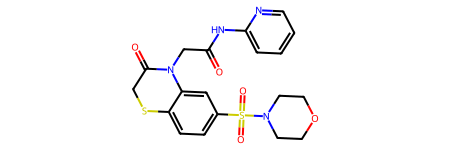

In [190]:
mol

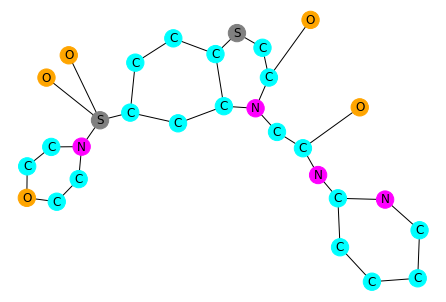

[[0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [2.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  2.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.

In [180]:
mol_nx = mol_to_nx(mol)

mol_atoms = nx.get_node_attributes(mol_nx, 'atom_symbol')
edge_weights = nx.get_edge_attributes(mol_nx, 'weight')

color_map = {'C': 'cyan',
             'O': 'orange',
             'N': 'magenta'}  

mol_colors = []
for idx in mol_nx.nodes():
    if (mol_nx.nodes[idx]['atom_symbol'] in color_map):
        mol_colors.append(color_map[mol_nx.nodes[idx]['atom_symbol']])
    else:
        mol_colors.append('gray')
    
nx.draw(mol_nx,
        labels=mol_atoms,
        with_labels = True,
        node_color=mol_colors,
        widths=edge_weights,
        node_size=300,
        pos=nx.kamada_kawai_layout(mol_nx))

plt.show()


# print out the adjacency matrix ---------------------------------------------- 
matrix = nx.to_numpy_matrix(mol_nx)
print(matrix)

In [178]:
mol_nx.edges[(0,1)]

{'weight': 2.0, 'bond_type': rdkit.Chem.rdchem.BondType.DOUBLE}